In [0]:
# To install cupy

!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   7053      0 --:--:-- --:--:-- --:--:--  7053
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
import cupy as cp
import numpy as np
import random
import time 
import matplotlib.pyplot as plt
from __future__ import print_function

In [0]:
def generateDNA(size):
    """
    generate a random sequence of DNA of the given size
    
    
    Parameters
    ----------
    size: int
        The size of the sequence generated
        
    Returns
    -------
    sequence: list
        A list where each element is choosen randomly between 'A', 'T', 'C' and 'G'
        
        
    Examples
    --------
    
    >>> generateDNA(7)
    ['C', 'C', 'G', 'T', 'A', 'T', 'G']

    """
    dict = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}
    sequence = []
    for i in range(size):
        sequence.append(dict[random.randint(0, 3)])
    return sequence

In [0]:
# Some hyper parameters

MATCH_SCORE_TWO_SEQ = 9
MISMATCH_SCORE_TWO_SEQ  = -3
GAP_SCORE = -2

In [0]:
def seqToNumber(sequence):
    
    """
    
    Convert a list of DNA characters to a list of number where each DNA character
    is converted to a number according to the dictionnary conversion_dict.
    
    
    Parameters
    ----------
    sequence: list
        the list of DNA characters to be converted
        
    Returns
    -------
    seqNumber: list
        A list of number where seqNumber[i] is the value of the dictionnary
        conversion_dict to the key sequence[i]
        
        
    Examples
    --------
    
    >>> seq = generateDNA(7)
    >>> print(seq)
    ['T', 'A', 'C', 'A', 'C', 'T', 'C']
    >>> seqToNumber(seq)
    [1, -1, -0.5, -1, -0.5, 1, -0.5]
    

    """
    conversion_dict = {'-': 0, 'A': -1, 'C': -0.5, 'G': 0.5, 'T': 1}
    seqNumber = []
    for _, value in enumerate(sequence):
            seqNumber.append(conversion_dict[value])
    return seqNumber

In [0]:
"""

Get a particular score for each cells that you want to compute in the Needleman 
and Wunch matrix by comparing if the characteres associate to a cell are identical

Parameters
----------
    
chars_line: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the line charactere in the matrix
    
chars_column: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the column charactere in the matrix
    
    
Returns
-------
1D array
    An array of the same size than the arrays in input where each elements of 
    this array has an information which tell if the charactere are identical
    and which one are identical

"""

def getScore(chars_line, chars_column):
    return cp.equal(chars_line, chars_column)

In [0]:
"""

Compute the Needleman and Wunch matrix for the comparaison of three sequences.

Parameters
----------
seq1, seq2: 1D array
    arrays of number where each number represent a DNA character. The first elements
    of the sequence must be the gap characere and be different for each sequences.
    
pos_in_seq1, pos_in_seq2, pos_in_seq3: 1D array
    arrays which indicate which character to compare for each cell in the Needleman
    and wunch algorithm.
    
cumul_nb_cells_computed: 1D array
    array which indicate the cumulative number of cells computed at each time step
    
position_in_nw_flatten_matrix: 1D array
    array which indicate the position of the cells to compute in a flatten 
    Needleman and Wunch matrix. The first element indicate the position 
    of the first cell to compute, the second element indicate the position
    of the second cell to compute...
    
Returns
-------
nw_matrix: 3D array
    The Needleman and Wunch matrix computed.
    
time_taken_each_step: list
    A list where each element of index i indicate the time passed to compute
    all the cells at the time step i.
    
    
    
IT IS QUICKER IF WE USE GLOBAL VAR INSTEAD OF PASSING VAR TO FUNCTION
THIS IS WHY THIS IS COMMENTED

"""

def computeScoringMatrix(seq1, seq2):#, pos_in_seq1, pos_in_seq2, pos_in_seq3, cumul_nb_cells_computed, position_in_nw_flatten_matrix):
    time_taken_each_step = []
    len_sequence = len(seq1)
    nw_matrix = cp.zeros((len_sequence + 1, len_sequence + 1), cp.int32) # Extend the length of each dimension by one in the needleman and Wunch matrix to not have problem wth boundaries


    nw_matrix[0, :] = nw_matrix[:, 0] = len_sequence*GAP_SCORE # Fill those boundaries with values which will never be choosen
    nw_matrix[0, 0] = -MISMATCH_SCORE_TWO_SEQ 


    nw_matrix_flatten = nw_matrix.ravel()
    shapeMatrix = nw_matrix.shape
    total_number_steps = 2 * len_sequence - 1 # See the theories to understand why the number of time step is that




    for step in range(1, total_number_steps + 1):
        begin = time.time()
        print("\r{} / {}".format(step, total_number_steps), end='')

        interval1 = cumul_nb_cells_computed[step-1]
        interval2 = cumul_nb_cells_computed[step]

        state_matrix = getScore(seq1[pos_in_seq1[interval1:interval2]], seq2[pos_in_seq2[interval1:interval2]])
        
        
        pos_cells_to_compute = position_in_nw_flatten_matrix[interval1:interval2]


        score_cells_line_minus1 = nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1)]
        score_cells_column_minus1 = nw_matrix_flatten[pos_cells_to_compute - 1]

        score_cells_line_column_minus1 = nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1) - 1]

        max_minus_one_dim = cp.maximum(score_cells_line_minus1, score_cells_column_minus1) + GAP_SCORE
        

        score_cells_line_column_minus1 +=  MISMATCH_SCORE_TWO_SEQ + state_matrix * MATCH_SCORE_TWO_SEQ

        


        # We put the maximum value in the matrix:
        nw_matrix_flatten[pos_cells_to_compute] = cp.maximum(max_minus_one_dim, score_cells_line_column_minus1)


        end = time.time()
        time_taken_each_step.append(end - begin)
    return nw_matrix, time_taken_each_step

In [0]:
"""
Converts a tuple of index arrays into an array of flat indices (just in dimmension 2)
Inputs : index: tuple of index arrays
shape : shape of the matrix
(See numpy : tuple_multi_index for more precision (this function is not implemented in cupy))
"""

def ravel_multi_index(index, shape): # Ne marche qu'en dimension 2
  return index[0][0] * shape[1] + index[1][0]

In [0]:
"""

Backtrack the Needleman and Wunch algorithm to find the optimal path

Parameters
----------
nw_matrix: 3D array
    The Needleman and Wunch matrix computed
    
    
Returns
-------
path: list of (3, 1) array
    A list of the optimal path where each element of the list contain the 
    depth, line and column position of the matrix
    
NOTE
--------
We use numpy instead of cupy because we compute one cell each time, so the CPU is 
much faster than the GPU for that kind of task.
    

"""


def determinatePath(nw_matrix):
    shapeMatrix = nw_matrix.shape
    a = np.zeros((3, ))
    vector_path = np.zeros((2, 1), np.int32)
    vector_path[0] = vector_path[1] = shapeMatrix[0] - 1
    path = []

    nw_matrix_flatten = nw_matrix.flatten()
    new_path = np.array([ [[1], [0]], [[0], [1]], [[1], [1]]  ])
    
   #Mask column :

    vector_mask_line = np.zeros((2, 1) ,np.int32)
    vector_mask_line[0][0] = 1

    vector_mask_column = np.zeros((2, 1), np.int32)
    vector_mask_column[1][0] = 1

    vector_mask_line_column = np.ones((2, 1), np.int32)



    while(1):
        path.append(vector_path)

        cell_to_backtrack = nw_matrix_flatten[ravel_multi_index(vector_path, shapeMatrix)]

        a[0] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_line, shapeMatrix)] + GAP_SCORE
        a[1] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_column, shapeMatrix)] + GAP_SCORE
        a[2] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_line_column, shapeMatrix)] + MISMATCH_SCORE_TWO_SEQ + np.equal(u1[vector_path[0][0]-1], u2[vector_path[1][0] - 1])* MATCH_SCORE_TWO_SEQ 
        
        
        pathTest = np.equal(a, cell_to_backtrack)
        index = np.argmax(pathTest)
        vector_path = vector_path - new_path[index]
        if (np.any(pathTest) == False or vector_path[0][0] == vector_path[1][0] == 1):
            path.append(vector_path)
            print("FINISH")
            return path


    return

In [0]:
"""

Use the optimal path to align the three sequences

Parameters
----------

seq1, seq2, seq3: list
  The three sequences.

path: list of arrays of shape (3, 1)
    The optimal path in the Needleman and Wunch matrix.
    
    
"""



def alignSequences(seq1, seq2, path):

    S1final =  seq1[:]
    S2final =  seq2[:]

    #print(S1final)
    #print(S2final)

    path = path[::-1]

    for i in range(len(path) - 1):
        p = path[i+1] - path[i]
        if (p[0][0] == 0):
            S1final.insert(i, '-')
        if (p[1][0] == 0):
            S2final.insert(i, '-')

    print(S1final)
    print(S2final)

In [0]:
# The main 

lenSequence = 192
lenSequence += 1 # To add the gap at the beginning of the sequences.



print("I BEGIN TO LOAD")
cumul_nb_cells_computed = cp.load("./2D_lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./2D_lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

pos_in_seq1 = cp.full((lenSequence**2, ), -1)
pos_in_seq1 += position_in_nw_flatten_matrix // (lenSequence+1)

pos_in_seq2 = cp.full((lenSequence**2, ), -1)
pos_in_seq2 += position_in_nw_flatten_matrix % (lenSequence+1)


print("FINISH TO LOAD")


seq1 = generateDNA(lenSequence-1)
seq2 = generateDNA(lenSequence-1)

print(seq1)
print(seq2)

sequenceNumber1 = seqToNumber(seq1)
sequenceNumber2 = seqToNumber(seq2)


# We add the gap character at the beginning of the sequences (the gap character must be different for each sequences)
u1 = cp.asarray([0.1] + sequenceNumber1) 
u2 = cp.asarray([0.2] + sequenceNumber2)


I BEGIN TO LOAD
FINISH TO LOAD
['G', 'G', 'A', 'G', 'C', 'A', 'T', 'G', 'G', 'C', 'C', 'C', 'T', 'G', 'G', 'A', 'T', 'T', 'G', 'G', 'T', 'C', 'G', 'C', 'A', 'T', 'C', 'A', 'T', 'C', 'C', 'C', 'G', 'A', 'G', 'T', 'C', 'A', 'G', 'C', 'G', 'T', 'G', 'T', 'C', 'C', 'A', 'A', 'T', 'C', 'A', 'A', 'G', 'T', 'G', 'G', 'T', 'A', 'G', 'A', 'G', 'G', 'T', 'G', 'C', 'A', 'A', 'T', 'A', 'C', 'T', 'G', 'C', 'T', 'T', 'A', 'T', 'T', 'G', 'T', 'A', 'C', 'A', 'G', 'A', 'T', 'T', 'T', 'T', 'C', 'A', 'A', 'C', 'G', 'T', 'T', 'C', 'G', 'C', 'C', 'G', 'A', 'A', 'T', 'A', 'C', 'T', 'T', 'C', 'A', 'A', 'G', 'T', 'G', 'G', 'A', 'T', 'A', 'A', 'T', 'T', 'G', 'C', 'T', 'G', 'G', 'C', 'T', 'T', 'G', 'A', 'C', 'T', 'G', 'G', 'A', 'G', 'T', 'A', 'A', 'A', 'A', 'T', 'C', 'C', 'A', 'G', 'T', 'C', 'A', 'C', 'G', 'G', 'A', 'C', 'T', 'C', 'C', 'C', 'A', 'C', 'A', 'G', 'C', 'A', 'T', 'C', 'C', 'A', 'C', 'T', 'G', 'G', 'G', 'A', 'T', 'C', 'C', 'A', 'G', 'T', 'G', 'T', 'G', 'A', 'G', 'A', 'A', 'G', 'C', 'A', 'G']
['C', 'C

In [0]:
    start = time.time()

    print("COMPUTE SCORE MATRIX : ")
    nw_matrix, time_taken_each_step = computeScoringMatrix(u1, u2)#, pos_in_seq1, pos_in_seq2, pos_in_seq3, cumul_nb_cells_computed, position_in_nw_flatten_matrix)
    #print(nw_matrix)

    end = time.time()
    print("\nTime to calculate the Needleman and Wunch matrix : {} seconds".format(end - start))

COMPUTE SCORE MATRIX : 
385 / 385
Time to calculate the Needleman and Wunch matrix : 0.652909040451 seconds


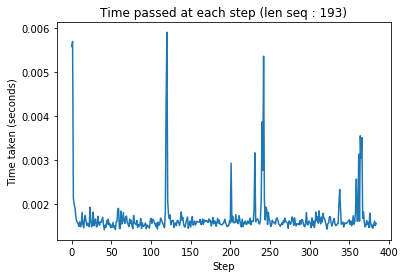

Mean : 0.001689229073462548
Var : 2.542690635457516e-07


In [0]:
plt.plot(list(cp.arange(len(time_taken_each_step))), time_taken_each_step)
plt.title("Time passed at each step (len seq : " + str(lenSequence) + ")")
plt.xlabel("Step")
plt.ylabel("Time taken (seconds)")
plt.show()

arrayTempsPasseAtEachStep = cp.asarray(time_taken_each_step[:])
print("Mean : {}\nVar : {}".format(arrayTempsPasseAtEachStep.mean(), arrayTempsPasseAtEachStep.var()))


In [0]:
  #print(nw_matrix)
  begin = time.time()
  print("DETERMINATE PASS : ")
  print(nw_matrix.shape)
  path = determinatePath(cp.asnumpy(nw_matrix))
  #print(path)

  print("ALIGN SEQUENCES : ")
  alignSequences(seq1, seq2, path)
  end = time.time()
  print("\nTime to baktrack the Needleman and Wunch matrix and align the sequences: {} seconds".format(end - begin))
  print("Len seq : {}".format(len(seq1)))

DETERMINATE PASS : 
(194, 194)
FINISH
ALIGN SEQUENCES : 
['-', '-', '-', '-', '-', 'G', 'G', 'A', 'G', 'C', 'A', '-', 'T', 'G', 'G', 'C', 'C', '-', '-', 'C', 'T', '-', '-', '-', 'G', '-', 'G', 'A', 'T', '-', '-', '-', '-', '-', 'T', '-', 'G', '-', '-', '-', '-', 'G', 'T', 'C', 'G', '-', 'C', 'A', 'T', 'C', 'A', 'T', 'C', 'C', 'C', 'G', '-', 'A', '-', '-', 'G', 'T', '-', 'C', '-', 'A', 'G', 'C', 'G', 'T', '-', 'G', 'T', 'C', 'C', 'A', 'A', 'T', 'C', '-', 'A', 'A', 'G', 'T', 'G', 'G', 'T', 'A', 'G', 'A', 'G', 'G', 'T', '-', 'G', 'C', 'A', 'A', 'T', 'A', 'C', 'T', 'G', 'C', 'T', 'T', 'A', '-', 'T', 'T', 'G', '-', '-', 'T', 'A', 'C', 'A', 'G', 'A', 'T', 'T', 'T', 'T', 'C', 'A', 'A', 'C', 'G', 'T', 'T', 'C', 'G', 'C', 'C', 'G', 'A', 'A', 'T', 'A', 'C', 'T', 'T', 'C', '-', 'A', 'A', '-', 'G', 'T', 'G', 'G', 'A', 'T', 'A', '-', 'A', 'T', 'T', 'G', 'C', 'T', 'G', '-', 'G', 'C', 'T', 'T', '-', 'G', '-', 'A', 'C', '-', '-', 'T', 'G', 'G', 'A', 'G', 'T', 'A', 'A', 'A', 'A', 'T', 'C', 'C', 'A', 'G